#Task-03

**A hand gesture recognition model that can accurately identify and classify different hand gestures from image or video data, enabling intuitive human-computer interaction and gesture-based control systems.**

In [1]:
!pip install opendatasets

In [2]:
# Importatnt Libraries
import keras
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import opendatasets as od
from keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


Dataset Loading

In [3]:
# Download dataset from Kaggle
od.download("https://www.kaggle.com/datasets/gti-upm/leapgestrecog/data")

Skipping, found downloaded files in "./leapgestrecog" (use force=True to force download)


 Define Categories

In [4]:
# Categories and image size
CLASSES = ["01_palm", '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok',
           '08_palm_moved', '09_c', '10_down']
IMG_SIZE = 50
dataset_dir = '/content/leapgestrecog/leapgestrecog/leapGestRecog'

# Preprocess dataset
gesture_data = []
for folder in os.listdir(dataset_dir):
    for gesture in CLASSES:
        gesture_index = CLASSES.index(gesture)
        gesture_path = os.path.join(dataset_dir, folder, gesture)
        for image in os.listdir(gesture_path):
            try:
                img_data = cv2.imread(os.path.join(gesture_path, image), cv2.IMREAD_GRAYSCALE)
                gesture_data.append([cv2.resize(img_data, (IMG_SIZE, IMG_SIZE)), gesture_index])
            except Exception as error:
                pass



####**Data Processing**

##### Shuffle Data, Separate Inputs and Labels

In [5]:
import random

In [6]:
# Shuffle data
random.shuffle(gesture_data)
# Separate input data and labels
features = []
targets = []

for img, lbl in gesture_data:
    features.append(img)
    targets.append(lbl)

features = np.array(features)
targets = np.array(targets)


Sample Images

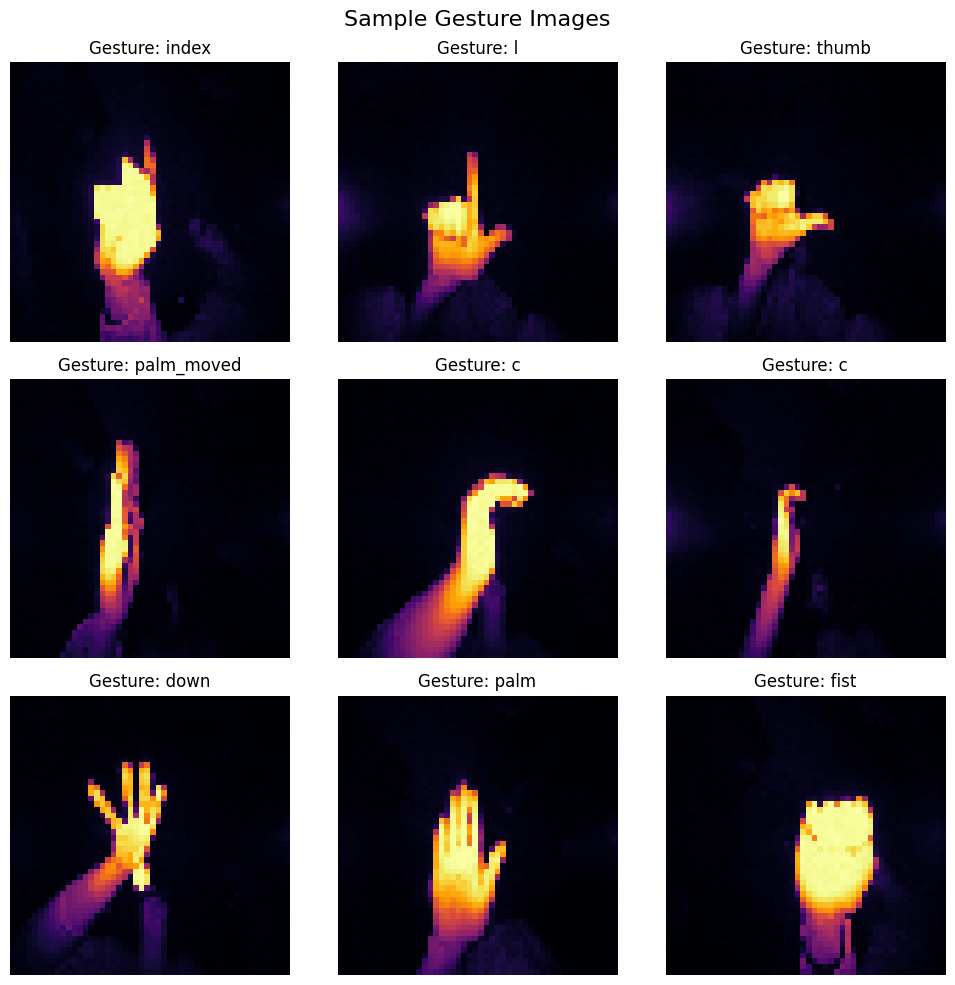

In [7]:
# Display some sample images
plt.figure(figsize=(10, 10))

for idx in range(9):
    plt.subplot(3, 3, idx + 1)
    plt.imshow(gesture_data[idx][0], cmap='inferno')
    plt.axis('off')  # Hides ticks and labels
    plt.title(f'Gesture: {CLASSES[targets[idx]][3:]}')

plt.suptitle('Sample Gesture Images', fontsize=16)
plt.tight_layout()
plt.show()


Prepare Data for Training

In [8]:
# Normalize features
features = features / 255.0
# One-hot encode
targets = keras.utils.to_categorical(targets, num_classes=10)

# Reshape features
features.shape = (-1, IMG_SIZE, IMG_SIZE, 1)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=0)


Define CNN Model

In [9]:
# Define CNN model with improvements
model = keras.models.Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3,3), input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Second Convolutional Block
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Third Convolutional Block
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])


 Train the Model

In [10]:
#learning rate reduction and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=2,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.00001)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),
          callbacks=[lr_reduction, early_stopping])

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 92s 201ms/step - accuracy: 0.3926 - loss: 2.1934 - val_accuracy: 0.1228 - val_loss: 11.0726 - learning_rate: 0.0010
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 92s 209ms/step - accuracy: 0.9013 - loss: 0.2823 - val_accuracy: 0.9770 - val_loss: 0.0541 - learning_rate: 0.0010
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 136s 197ms/step - accuracy: 0.9589 - loss: 0.1178 - val_accuracy: 0.9992 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 146s 207ms/step - accuracy: 0.9730 - loss: 0.0802 - val_accuracy: 0.9985 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9818 - loss: 0.0615
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
438/438 ━━━━━━━━━━━━━━━━━━━━ 87s 199ms/step - accuracy: 0.9818 - loss: 0.0615 - val_accuracy: 0.9980 - val_loss: 0.0081 - learning_rate: 0.0010
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 141s 197ms/step - accuracy: 0

Plot Training and Validation Accuracy

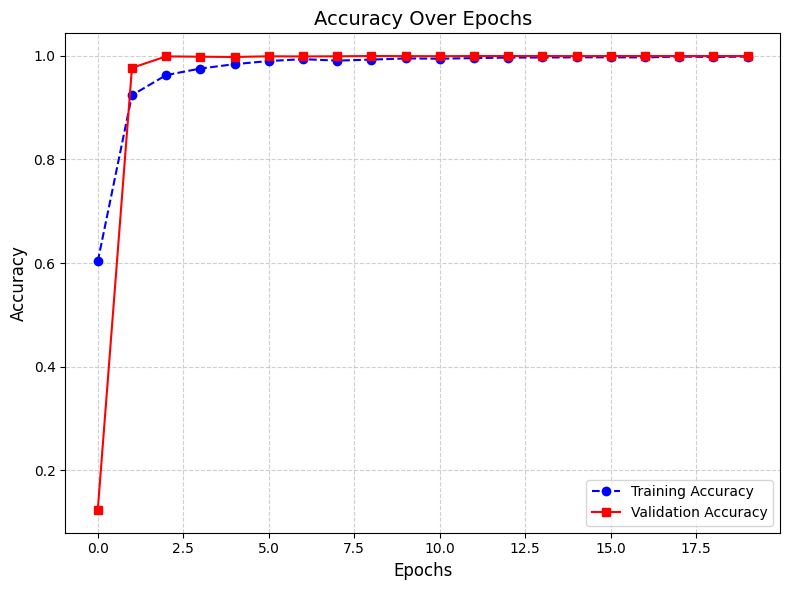

In [11]:
# Plot accuracy
plt.figure(figsize=(8, 6))
\
# training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', linestyle='--', marker='o', color='b')

# validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='-', marker='s', color='r')

# Customize the plot
plt.title('Accuracy Over Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epochs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Add legend
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Model Evaluation

In [12]:
# Model evaluation
evaluation_metrics = model.evaluate(X_test, y_test, verbose=0)

#test loss and accuracy
final_loss, final_accuracy = evaluation_metrics
print(f'Accuracy on test set: {final_accuracy * 100:.2f}%')


Accuracy on test set: 99.98%


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step


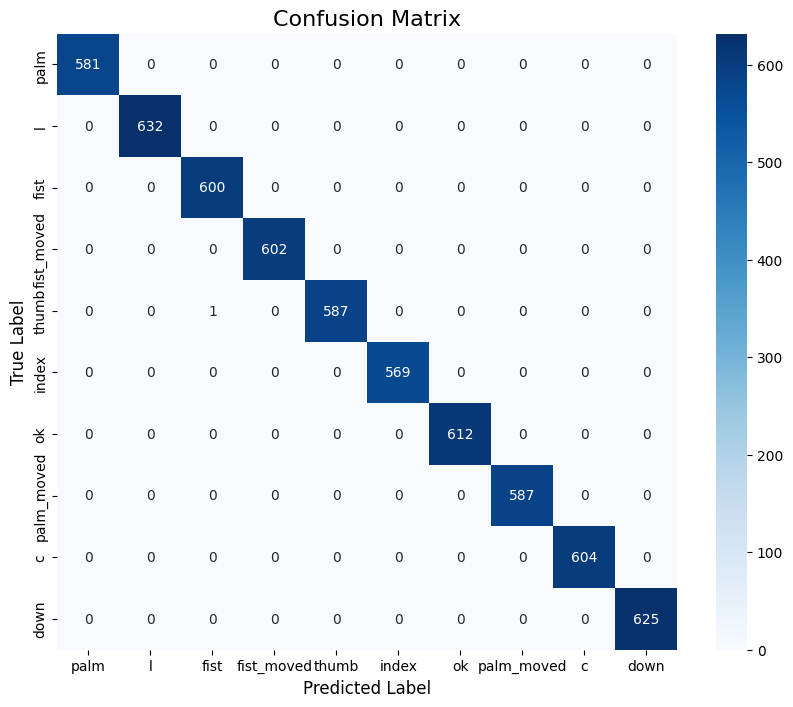

In [14]:
# Create a confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1))

# category labels
gesture_labels = [gesture[3:] for gesture in CLASSES]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=gesture_labels, yticklabels=gesture_labels)

# plot appearance
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()